# 

In [1]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
import torch.nn.functional as F
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import seaborn as sns
import muon as mu
import anndata

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(t): return torch.tensor(t).to(device)

/scratch/venvs/deeplife2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir="/scratch/deeplife/"
pbmc = sc.read_10x_h5(dir+"5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
pbmc.var_names_make_unique()
pbmc.layers["counts"] = pbmc.X.copy()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
protein = pbmc[:, pbmc.var["feature_types"] == "Antibody Capture"].copy()
rna = pbmc[:, pbmc.var["feature_types"] == "Gene Expression"].copy()


In [52]:
class FA(PyroModule):
    def __init__(self, Y, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.obs_mask = torch.logical_not(torch.isnan(Y))
        self.Y = torch.nan_to_num(Y, nan=0)
        self.K = K
        self.batch_size = 128
        
        self.num_samples = self.Y.shape[0]
        self.num_features = self.Y.shape[1]
        
        # self.sample_plate = pyro.plate("sample", self.num_samples, subsample_size=self.batch_size)
        self.feature_plate = pyro.plate("feature", self.num_features)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
        
    def model(self):
        """
        how to generate a matrix
        """
        sample_plate = pyro.plate("sample", self.num_samples, subsample_size=self.batch_size)
        with self.latent_factor_plate:
            with self.feature_plate:
                # sample weight matrix with Normal prior distribution
                W = pyro.sample("W", pyro.distributions.Normal(0., to_device(1.0)))                
                
            with sample_plate as batch_ix:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., to_device(1.0)))
        
        # estimate for Y
        Y_hat = torch.matmul(Z, W.t())
        # print(Z.shape, W.shape, self.Y.shape, Y_hat.shape)
        
        with pyro.plate("feature_", self.Y.shape[1]):
            # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
            # scale = pyro.sample("scale", pyro.distributions.LogNormal(0., to_device(1.0)))
            scale = pyro.sample("scale", pyro.distributions.Uniform(0.0, to_device(100.0)))
            with sample_plate as batch_ix:
                #print(scale.detach())
                #print(f"mean={scale.detach().mean().cpu().numpy()}  min={scale.detach().min().cpu().numpy()}   max={scale.detach().max().cpu().numpy()}")
                # print(batch_ix)
                # masking the NA values such that they are not considered in the distributions
                with pyro.poutine.mask(mask=self.obs_mask[batch_ix, :]):
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
            
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs", pyro.distributions.Normal(Y_hat, scale), obs=self.Y[batch_ix, :])


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.002})
        elbo = Trace_ELBO()
        guide = autoguide.AutoNormal(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 60_000
        train_loss = []
        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y.shape[0])
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y.shape[0]))
        
        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(self.Y)
        
        return train_loss, map_estimates, guide


In [53]:
factor_model = FA(Y = torch.tensor(rna.X.toarray()).to(device), K = 5)
loss, map_estimates, trained_guide = factor_model.train()

[iteration 0001] loss: 162119.8803
[iteration 0201] loss: 154460.2603
[iteration 0401] loss: 144707.4835
[iteration 0601] loss: 133191.5806
[iteration 0801] loss: 120160.7485
[iteration 1001] loss: 106331.8921
[iteration 1201] loss: 92144.6985
[iteration 1401] loss: 77877.3563
[iteration 1601] loss: 63774.6607
[iteration 1801] loss: 50057.6650
[iteration 2001] loss: 36899.8456
[iteration 2201] loss: 24180.5063
[iteration 2401] loss: 12603.2102
[iteration 2601] loss: 2066.6928
[iteration 2801] loss: -7422.3538
[iteration 3001] loss: -15814.6726
[iteration 3201] loss: -24325.0462
[iteration 3401] loss: -31139.4207
[iteration 3601] loss: -36855.9964
[iteration 3801] loss: -42049.5624
[iteration 4001] loss: -49464.4482
[iteration 4201] loss: -53904.2678
[iteration 4401] loss: -57830.7076
[iteration 4601] loss: -64361.3945
[iteration 4801] loss: -68457.5558
[iteration 5001] loss: -73401.0878
[iteration 5201] loss: -76631.0639
[iteration 5401] loss: -81754.0687
[iteration 5601] loss: -86018.

(-160454.0, -120454.0)

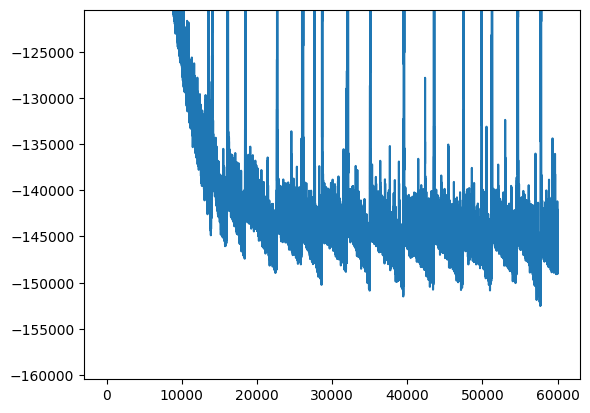

In [60]:
plt.plot(loss)
plt.gca().set_ylim(-160454, -120454)

In [6]:
print({ k: v.shape for k, v in map_estimates.items() })
print(trained_guide(factor_model.Y))

{'W': torch.Size([32, 5]), 'Z': torch.Size([128, 5]), 'scale': torch.Size([32])}
{'W': tensor([[-6.2167e+00, -5.2375e-01, -7.7624e-01,  3.0418e-01, -8.0985e-01],
        [-6.1623e+00, -7.2304e-01,  2.9042e-01, -2.1444e-01, -4.4527e-01],
        [-6.8224e+00,  6.1868e-01,  3.4788e-01,  8.5167e-01,  5.6037e-01],
        [-1.5568e+00,  2.5900e+00,  5.8083e-01, -1.1871e+00,  5.8991e-01],
        [-5.4821e+00,  1.5774e+00, -1.2959e+00,  4.1011e-01,  7.5367e-01],
        [-5.1276e+00, -5.5158e-01, -5.5784e-01, -4.7073e-03,  2.4762e-01],
        [-7.1638e+00, -1.2572e+00, -3.1621e-02, -7.5473e-02,  3.5284e-01],
        [-7.2740e+00,  4.8160e-01,  1.0264e+00,  1.1063e+00, -1.3849e+00],
        [-3.5273e+00, -1.6637e+00, -1.8072e+00,  2.0724e-01,  5.0200e-01],
        [-5.1282e+00, -5.6967e-01, -1.1237e-01,  2.2688e-01, -2.6654e-01],
        [-9.8822e+00,  2.7053e-01, -2.8745e+00, -7.5783e-01, -2.7193e-02],
        [-1.7472e+01,  4.5629e-01, -4.2366e-01, -3.1488e-01,  5.1795e-01],
        [-8.3

In [7]:
print(pyro.get_param_store().get_all_param_names())
pyro.get_param_store().get_param("AutoNormal.locs.scale")

dict_keys(['AutoNormal.locs.W', 'AutoNormal.scales.W', 'AutoNormal.locs.Z', 'AutoNormal.scales.Z', 'AutoNormal.locs.scale', 'AutoNormal.scales.scale'])


Parameter containing:
tensor([ 6.1686,  6.7222,  4.9494,  7.1456,  6.1135,  3.6600,  4.4253,  4.9282,
         5.5480,  3.1226,  5.7945,  4.7862, -0.6547,  6.1421,  4.3899,  4.2770,
         4.1401,  3.5831,  1.7779,  4.7436,  3.9515,  2.1641,  3.1102,  2.6019,
         4.5050,  3.1883,  3.3112,  6.4447,  2.7273,  2.3221,  2.1633,  2.5633],
       device='cuda:0', requires_grad=True)